#Correlation Functions

###Contents

- [Two-Time Correlation Functions](#twotime)
- [Steady State Correlation Functions](#steady)
- [Emission Spectrum](#emission)
- [Non-Steady State Correlation Function](#nonsteady)

In [2]:
%matplotlib inline
import numpy as np
from pylab import *
from qutip import *

<a id='twotime'></a>

##Two-Time Correlation Functions

With the QuTiP time-evolution functions (for example `mesolve` and `mcsolve`), a state vector or density matrix can be evolved from an initial state at :math:`t_0` to an arbitrary time $t$, $\rho(t)=V(t, t_0)\left\{\rho(t_0)\right\}$, where $V(t, t_0)$ is the propagator defined by the equation of motion. The resulting density matrix can then be used to evaluate the expectation values of arbitrary combinations of *same-time* operators.

To calculate *two-time* correlation functions on the form $\left<A(t+\tau)B(t)\right>$, we can use the quantum regression theorem to write

$$
    \left<A(t+\tau)B(t)\right> = {\rm Tr}\left[A V(t+\tau, t)\left\{B\rho(t)\right\}\right]
                               = {\rm Tr}\left[A V(t+\tau, t)\left\{BV(t, 0)\left\{\rho(0)\right\}\right\}\right]
$$

We therefore first calculate $\rho(t)=V(t, 0)\left\{\rho(0)\right\}$ using one of the QuTiP evolution solvers with $\rho(0)$ as initial state, and then again use the same solver to calculate $V(t+\tau, t)\left\{B\rho(t)\right\}$ using $B\rho(t)$ as the initial state.  Note that if the intial state is the steady state, then $\rho(t)=V(t, 0)\left\{\rho_{\rm ss}\right\}=\rho_{\rm ss}$ and 

$$
 \left<A(t+\tau)B(t)\right> = {\rm Tr}\left[A V(t+\tau, t)\left\{B\rho_{\rm ss}\right\}\right] 
                               = {\rm Tr}\left[A V(\tau, 0)\left\{B\rho_{\rm ss}\right\}\right] = \left<A(\tau)B(0)\right>,
$$

which is independent of $t$, so that we only have one time coordinate $\tau$.


QuTiP provides a family of functions that assists in the process of calculating two-time correlation functions. The available functions and their usage is show in the table below. Each of these functions can use one of the following evolution solvers: Master-equation, Exponential series and the Monte-Carlo. The choice of solver is defined by the optional argument ``solver``. 


<table>
  <tr>
    <th>QuTiP Function</th>
    <th>Correlation Function Type</th>
  </tr>
  <tr>
    <td>`correlation` or `correlation_2op_2t`</td>
    <td>$\left<A(t+\tau)B(t)\right>$ or $\left<A(t)B(t+\tau)\right>$. </td>
  </tr>
  <tr>
    <td>`correlation_ss` or `correlation_2op_1t`</td>
    <td>$\left<A(\tau)B(0)\right>$ or $\left<A(0)B(\tau)\right>$.</td>
  </tr>
  <tr>
    <td>`correlation_3op_1t`</td>
    <td>$\left<A(0)B(\tau)C(0)\right>$.</td>
  </tr>
  <tr>
    <td>`correlation_3op_2t`</td>
    <td>$\left<A(t)B(t+\tau)C(t)\right>$.</td>
  </tr>
  <tr>
    <td>`correlation_4op_1t` <font color='red'>(Depreciated)</font></td>
    <td>$\left<A(0)B(\tau)C(\tau)D(0)\right>$</td>
  </tr>
  <tr>
    <td>`correlation_4op_2t` <font color='red'>(Depreciated)</font></td>
    <td style='min-width:200px'>$\left<A(t)B(t+\tau)C(t+\tau)D(t)\right>$ </td>
  </tr>
</table>

The most common use-case is to calculate correlation functions of the kind $\left<A(\tau)B(0)\right>$, in which case we use the correlation function solvers that start from the steady state, e.g., the `correlation_2op_1t` function. These correlation function solvers return a vector or matrix (in general complex) with the correlations as a function of the delay times. 

<a id='steady'></a>

##Steady State Correlation Function

The following code demonstrates how to calculate the $\left<x(t)x(0)\right>$ correlation for a leaky cavity with three different relaxation rates.

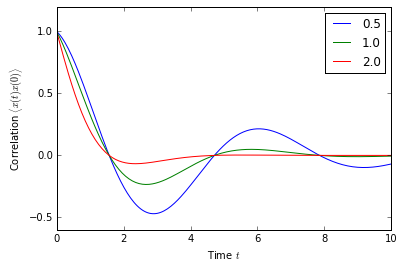

In [7]:
times = np.linspace(0,10.0,200)
a = destroy(10)
x = a.dag() + a
H = a.dag() * a
corr1 = correlation_2op_1t(H, None, times, [np.sqrt(0.5) * a], x, x)
corr2 = correlation_2op_1t(H, None, times, [np.sqrt(1.0) * a], x, x)
corr3 = correlation_2op_1t(H, None, times, [np.sqrt(2.0) * a], x, x)

plot(times, np.real(corr1), times, np.real(corr2), times, np.real(corr3))
legend(['0.5','1.0','2.0'])
xlabel(r'Time $t$')
ylabel(r'Correlation $\left<x(t)x(0)\right>$')
show()

<a id='emission'></a>

##Emission Spectrum

Given a correlation function $\left<A(\tau)B(0)\right>$ we can define the corresponding power spectrum as

$$
S(\omega) = \int_{-\infty}^{\infty} \left<A(\tau)B(0)\right> e^{-i\omega\tau} d\tau.
$$

In QuTiP, we can calculate $S(\omega)$ using either `spectrum`, which first calculates the correlation function using the `essolve` solver and then performs the Fourier transform semi-analytically, or we can use the function `spectrum_correlation_fft` to numerically calculate the Fourier transform of a given correlation data using FFT.  

The following example demonstrates how these two functions can be used to obtain the emission power spectrum.

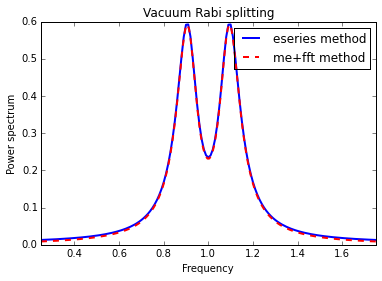

In [10]:
N = 4                      # number of cavity fock states
wc = wa = 1.0 * 2 * np.pi  # cavity and atom frequency
g  = 0.1 * 2 * np.pi       # coupling strength
kappa = 0.75               # cavity dissipation rate
gamma = 0.25               # atom dissipation rate

# Jaynes-Cummings Hamiltonian
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

# collapse operators
n_th = 0.25
c_ops = [np.sqrt(kappa * (1 + n_th)) * a, 
         np.sqrt(kappa * n_th) * a.dag(), np.sqrt(gamma) * sm]

# calculate the correlation function using the mesolve solver, and then fft to
# obtain the spectrum. Here we need to make sure to evaluate the correlation
# function for a sufficient long time and sufficiently high sampling rate so 
# that the discrete Fourier transform (FFT) captures all the features in the
# resulting spectrum.
tlist = np.linspace(0, 100, 5000)
corr = correlation_2op_1t(H, None, tlist, c_ops, a.dag(), a)
wlist1, spec1 = spectrum_correlation_fft(tlist, corr)


# calculate the power spectrum using spectrum, which internally uses essolve
# to solve for the dynamics (by default)
wlist2 = np.linspace(0.25, 1.75, 200) * 2 * np.pi
spec2 = spectrum(H, wlist2, c_ops, a.dag(), a)

# plot the spectra
fig, ax = subplots(1, 1)
ax.plot(wlist1 / (2 * np.pi), spec1, 'b', lw=2, label='eseries method')
ax.plot(wlist2 / (2 * np.pi), spec2, 'r--', lw=2, label='me+fft method')
ax.legend()
ax.set_xlabel('Frequency')
ax.set_ylabel('Power spectrum')
ax.set_title('Vacuum Rabi splitting')
ax.set_xlim(wlist2[0]/(2*np.pi), wlist2[-1]/(2*np.pi))
show()

<a id='nonsteady'></a>

##Non-Steady State Correlation Function

More generally, we can also calculate correlation functions of the kind $\left<A(t_1+t_2)B(t_1)\right>$, i.e., the correlation function of a system that is not in its steadystate. In QuTiP, we can evoluate such correlation functions using the function `correlation_2op_2t`. The default behavior of this function is to return a matrix with the correlations as a function of the two time coordinates ($t_1$ and $t_2$).

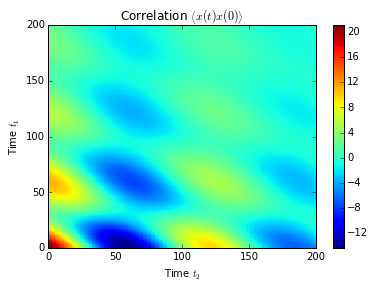

In [18]:
times = np.linspace(0, 10.0, 200)
a = destroy(10)
x = a.dag() + a
H = a.dag() * a
alpha = 2.5
rho0 = coherent_dm(10, alpha)
corr = correlation_2op_2t(H, rho0, times, times, [np.sqrt(0.25) * a], x, x)

pcolor(np.real(corr))
colorbar()
xlabel(r'Time $t_2$')
ylabel(r'Time $t_1$')
title(r'Correlation $\left<x(t)x(0)\right>$')
show()

However, in some cases we might be interested in the correlation functions on the form $\left<A(t_1+t_2)B(t_1)\right>$, but only as a function of time coordinate $t_2$. In this case we can also use the `correlation_2op_2t` function, if we pass the density matrix at time $t_1$ as second argument, and `None` as third argument. The `correlation_2op_2t` function then returns a vector with the correlation values corresponding to the times in `taulist` (the fourth argument).

###Ex: First-Order Optical Coherence Function

This example demonstrates how to calculate a correlation function on the form $\left<A(\tau)B(0)\right>$ for a non-steady initial state. Consider an oscillator that is interacting with a thermal environment. If the oscillator initially is in a coherent state, it will gradually decay to a thermal (incoherent) state. The amount of coherence can be quantified using the first-order optical coherence function 
$$
g^{(1)}(\tau) = \frac{\left<a^\dagger(\tau)a(0)\right>}{\sqrt{\left<a^\dagger(\tau)a(\tau)\right>\left<a^\dagger(0)a(0)\right>}}.
$$ 
For a coherent state $|g^{(1)}(\tau)| = 1$, and for a completely incoherent (thermal) state $g^{(1)}(\tau) = 0$. The following code calculates and plots $g^{(1)}(\tau)$ as a function of $\tau$.

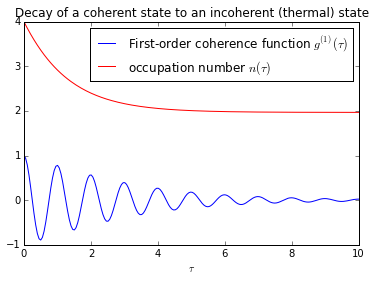

In [14]:
N = 15
taus = np.linspace(0,10.0,200)
a = destroy(N)
H = 2 * np.pi * a.dag() * a

# collapse operator
G1 = 0.75
n_th = 2.00  # bath temperature in terms of excitation number
c_ops = [np.sqrt(G1 * (1 + n_th)) * a, np.sqrt(G1 * n_th) * a.dag()]

# start with a coherent state
rho0 = coherent_dm(N, 2.0)

# first calculate the occupation number as a function of time
n = mesolve(H, rho0, taus, c_ops, [a.dag() * a]).expect[0]

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = correlation_2op_2t(H, rho0, None, taus, c_ops, a.dag(), a)
g1 = G1 / np.sqrt(n[0] * n)

plot(taus, np.real(g1), 'b')
plot(taus, n, 'r')
title('Decay of a coherent state to an incoherent (thermal) state')
xlabel(r'$\tau$')
legend((r'First-order coherence function $g^{(1)}(\tau)$', 
        r'occupation number $n(\tau)$'))
show()

For convenience, the steps for calculating the first-order coherence function have been collected in the function `coherence_function_g1`.


###Example: Second-Order Optical Coherence Function

The second-order optical coherence function, with time-delay $\tau$, is defined as

$$
\displaystyle g^{(2)}(\tau) = \frac{\langle a^\dagger(0)a^\dagger(\tau)a(\tau)a(0)\rangle}{\langle a^\dagger(0)a(0)\rangle^2}
$$

For a coherent state $g^{(2)}(\tau) = 1$, for a thermal state $g^{(2)}(\tau=0) = 2$ and it decreases as a function of time (bunched photons, they tend to appear together), and for a Fock state with $n$ photons $g^{(2)}(\tau = 0) = n(n - 1)/n^2 < 1$ and it increases with time (anti-bunched photons, more likely to arrive separated in time).  

To calculate this type of correlation function with QuTiP, we could use `correlation_4op_1t`, which computes a correlation function of the form $\left<A(0)B(\tau)C(\tau)D(0)\right>$ (four operators, one delay-time vector).  However, the middle pair of operators are evaluated at the same time $\tau$, and thus can be simplified to a single operator $E(\tau)=B(\tau)C(\tau)$, and we can instead call the `correlation_3op_1t` function to compute $\left<A(0)E(\tau)D(0)\right>$.  This simplification is done automatically inside the depreciated `correlation_4op_1t` function that calls `correlation_3op_1t` internally.

The following code calculates and plots $g^{(2)}(\tau)$ as a function of $\tau$ for coherent, thermal and fock states.

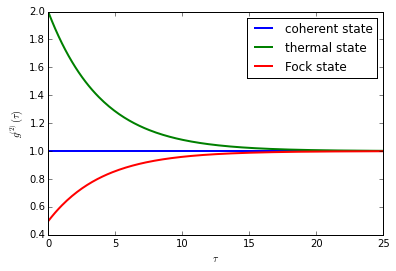

In [17]:
N = 25
taus = np.linspace(0, 25.0, 200)
a = destroy(N)
H = 2 * np.pi * a.dag() * a

kappa = 0.25
n_th = 2.0  # bath temperature in terms of excitation number
c_ops = [np.sqrt(kappa * (1 + n_th)) * a, np.sqrt(kappa * n_th) * a.dag()]

states = [{'state': coherent_dm(N, np.sqrt(2)), 'label': "coherent state"},
          {'state': thermal_dm(N, 2), 'label': "thermal state"},
          {'state': fock_dm(N, 2), 'label': "Fock state"}]

fig, ax = subplots(1, 1)

for state in states:
    rho0 = state['state']

    # first calculate the occupation number as a function of time
    n = mesolve(H, rho0, taus, c_ops, [a.dag() * a]).expect[0]

    # calculate the correlation function G2 and normalize with n(0)n(t) to
    # obtain g2
    G2 = correlation_3op_1t(H, rho0, taus, c_ops, a.dag(), a.dag() * a, a)
    g2 = G2 / (n[0] * n)

    ax.plot(taus, np.real(g2), label=state['label'], lw=2)

ax.legend(loc=0)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$g^{(2)}(\tau)$')
show()

For convenience, the steps for calculating the second-order coherence function have been collected in the function `coherence_function_g2`.

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/guide.css", "r").read()
    return HTML(styles)
css_styling()